# Object Detection using Amazon SageMaker - Advanced (Transfer Learning with ResNet50 with SSD)

Introduction
Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found. It also identifies what type of object the box encapsulates. To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.

This notebook is an end-to-end example showing how the Amazon SageMaker Object Detection algorithm can be used with a publicly available dataset of bird images. We demonstrate how to train and to host an object detection model based on the Caltech Birds (CUB 200 2011) dataset. Amazon SageMaker's object detection algorithm uses the Single Shot multibox Detector (SSD) algorithm, and this notebook uses a ResNet base network with that algorithm.

We use the Caltech Birds (CUB 200 2011) dataset, which contains 11,788 images across 200 bird species. Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels. Bounding boxes and annotations are provided. A recommended train/test split is given, but image size data is not.

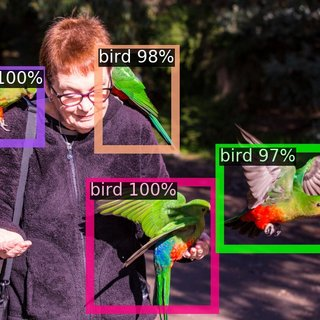

In [2]:
from IPython.display import Image
file_name1 = './img/bird.jpg'
Image(file_name1)

In this notebook, we see
- How to translate bounding box specifications when providing images to SageMaker's algorithm. You will see code for generating the train.lst and val.lst files used to create recordIO files.
- How to improve an object detection model by adding training images that are flipped horizontally (mirror images).
- More classes (200 bird species, as opposed to the 20 categories used by Pascal VOC).
- Visulizae the accuracy improvements that occur across the epochs of the training job.

In [27]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv

import cv2

import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [5]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'objectdetection'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x0000018544B9C508>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : objectdetection
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(region, 'object-detection', repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:latest


### 2. Load Data

Dataset can be directly donwloaded from Caltech computervision website [Link](http://www.vision.caltech.edu/) 

In [7]:
def download(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')        

In [12]:
# Unzip the Tar.gz file
import tarfile
my_tar = tarfile.open('CUB_200_2011.tgz')
my_tar.extractall('./data')
my_tar.close()

### 3. Data Preprocessing

Amazon team have provided helpfer functionfiles in the tools folder.

- patch_ssd.sh - this is a bash script for patching the model artifacts to be suitable for running on AWS DeepLens. \
- birdsOnEdge.py - this is a Python script that can be deployed as AWS Lambda inference function on AWS DeepLens. It depends on the patched model artifacts and performs the necessary additional step of calling mo.optimize before loading the model. \
- im2rec.py - this is a copy of a Python script from Apache MXNet that is used by the notebook to create RecordIO files of the bird images.

##### Set some parameters for the rest of the notebook to use
Here we define a few parameters that help drive the rest of the notebook. For example, **SAMPLE_ONLY** is defaulted to **True**. This will force the notebook to train on only a handful of species. Setting to false will make the notebook work with the entire dataset of 200 bird species. This makes the training a more difficult challenge, and you will need many more epochs to complete.

In [13]:
runtime = boto3.client(service_name='runtime.sagemaker')

RANDOM_SPLIT = False
SAMPLE_ONLY  = True
FLIP         = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [17, 36, 47, 68, 73]

# Otherwise, you can use the full set of species
if (not SAMPLE_ONLY):
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR   = './data/CUB_200_2011/'
IMAGES_DIR = BASE_DIR + 'images/'

CLASSES_FILE = BASE_DIR + 'classes.txt'
BBOX_FILE    = BASE_DIR + 'bounding_boxes.txt'
IMAGE_FILE   = BASE_DIR + 'images.txt'
LABEL_FILE   = BASE_DIR + 'image_class_labels.txt'
SIZE_FILE    = BASE_DIR + 'sizes.txt'
SPLIT_FILE   = BASE_DIR + 'train_test_split.txt'

TRAIN_LST_FILE = 'birds_ssd_train.lst'
VAL_LST_FILE   = 'birds_ssd_val.lst'

if (SAMPLE_ONLY):
    TRAIN_LST_FILE = 'birds_ssd_sample_train.lst'
    VAL_LST_FILE   = 'birds_ssd_sample_val.lst'

TRAIN_RATIO     = 0.8
CLASS_COLS      = ['class_number','class_id']
IM2REC_SSD_COLS = ['header_cols', 'label_width', 'zero_based_id', 'xmin', 'ymin', 'xmax', 'ymax', 'image_file_name']

##### Explore the dataset images
For each species, there are dozens of images of various shapes and sizes. By dividing the entire dataset into individual named (numbered) folders, the images are in effect labelled for supervised learning using image classification and object detection algorithms.

The following function displays a grid of thumbnail images for all the image files for a given species.

In [21]:
def show_species(species_id):
    _im_list = IMAGES_DIR + species_id

    NUM_COLS = 6
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(8.0, 16.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()       
    plt.show()
        
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

In [22]:
# Show the list of bird species or dataset classes.
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]
print(classes_df.to_csv(columns=['class_id'], sep='\t', index=False, header=False))

017.Cardinal
036.Northern_Flicker
047.American_Goldfinch
068.Ruby_throated_Hummingbird
073.Blue_Jay



In [ ]:
# Now for any given species, display thumbnail images of each of the images provided for training and testing.
show_species('017.Cardinal')

### 4. Generate RecordIO files

##### [1] Gather image sizes

For this particular dataset, bounding box annotations are specified in absolute terms. RecordIO format requires them to be defined in terms relative to the image size. The following code visits each image, extracts the height and width, and saves this information into a file for subsequent use. Some other publicly available datasets provide such a file for exactly this purpose

In [28]:
SIZE_COLS = ['idx','width','height']

def gen_image_size_file():
    print('Generating a file containing image sizes...')
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    rows_list = []
    idx = 0
    for i in images_df['image_file_name']:
        # TODO: add progress bar
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        dimensions = img.shape
        height = img.shape[0]
        width = img.shape[1]
        image_dict = {'idx': idx, 'width': width, 'height': height}
        rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print('Image sizes:\n' + str(sizes_df.head()))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=' ', index=False, header=None)

In [29]:
%%time
gen_image_size_file()

Generating a file containing image sizes...
Image sizes:
   idx  width  height
0    1    500     335
1    2    500     336
2    3    500     347
3    4    415     500
4    5    331     380
Wall time: 1min 40s


##### [2] Generate list files for producing RecordIO files

For this dataset, we need to convert absolute bounding box dimensions to relative dimensions based on image size. We also need to adjust class id's to be zero-based (instead of 1 to 200, they need to be 0 to 199). This dataset comes with recommended train/test split information ("is_training_image" flag). This notebook is built flexibly to either leverage this suggestion, or to create a random train/test split with a specific train/test ratio. The RAMDOM_SPLIT variable defined earlier controls whether or not the split happens randomly.

In [30]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}'.format(lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df

def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(SIZE_FILE, sep=' ',
                names=['image_pretty_name', 'width', 'height'],
                header=None)
    bboxes_df = pd.read_csv(BBOX_FILE, sep=' ',
                names=['image_pretty_name', 'x_abs', 'y_abs', 'bbox_width', 'bbox_height'],
                header=None)
    split_df = pd.read_csv(SPLIT_FILE, sep=' ',
                            names=['image_pretty_name', 'is_training_image'],
                            header=None)
    print(IMAGE_FILE)
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    print('num images total: ' + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(LABEL_FILE, sep=' ',
                                names=['image_pretty_name', 'class_id'], header=None)

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')
    full_df = pd.merge(full_df, sizes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, bboxes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, split_df, on='image_pretty_name')
    full_df.sort_values(by=['index'], inplace=True)

    # Define the bounding boxes in the format required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df['header_cols'] = 2  # one col for the number of header cols, one for the label width
    full_df['label_width'] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    full_df['xmin'] = full_df['x_abs'] / full_df['width']
    full_df['xmax'] = (full_df['x_abs'] + full_df['bbox_width']) / full_df['width']
    full_df['ymin'] = full_df['y_abs'] / full_df['height']
    full_df['ymax'] = (full_df['y_abs'] + full_df['bbox_height']) / full_df['height']

    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['class_id'].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df['class_id'].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df['zero_based_id'] = full_df['class_id'].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if (RANDOM_SPLIT):
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, 'class_id', TRAIN_RATIO)

        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
    else:
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        
    print('num train: ' + str(train_df.shape[0]))
    print('num val: ' + str(val_df.shape[0]))
    return train_df, val_df

In [31]:
train_df, val_df = gen_list_files()

./data/CUB_200_2011/images.txt
num images total: 11788
num train: 150
num val: 147


Here we take a look at a few records from the training list file to understand better what is being fed to the RecordIO files.

The first column is the image number or index. The second column indicates that the label is made up of 2 columns (column 2 and column 3). The third column specifies the label width of a single object. In our case, the value 5 indicates each image has 5 numbers to describe its label information: the class index, and the 4 bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. Our dataset contains only one bounding box per image.

The fourth column is the class label. This identifies the bird species using a zero-based class id. Columns 4 through 7 represent the bounding box for where the bird is found in this image.

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file within the images directory.

##### [3] Convert data into RecordIO format

In [32]:
# im2rec databases (.rec files) for training and validatio
!python ./tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/

Creating .rec file from C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\birds_ssd_sample_train.lst in C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker
multiprocessing not available, fall back to single threaded encoding
time: 0.021941184997558594  count: 0
Creating .rec file from C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\birds_ssd_sample_val.lst in C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker
multiprocessing not available, fall back to single threaded encoding
time: 0.012964010238647461  count: 0


### 5. Upload RecordIO files to S3

Upload the training and validation data to the S3 bucket. We do this in **multiple channels**. Channels are simply directories in the bucket that differentiate the types of data provided to the algorithm. For the object detection algorithm, we call these directories train and validation.

In [33]:
# Upload the RecordIO files to train and validation channels
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='birds_ssd_sample_train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='birds_ssd_sample_val.rec', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

### 6. Create a Model

In [60]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 36000, # 360000
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

##### Define hyperparameters

The object detection algorithm at its core is the Single-Shot Multi-Box detection algorithm (SSD). This algorithm uses a base_network, which is typically a VGG or a ResNet. The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50. It also has a number of hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. See the SageMaker Object Detection documentation for more details on its specific hyperparameters.

One of the hyperparameters here for example is epochs. This defines how many passes of the dataset we iterate over and drives the training time of the algorithm. Based on our tests, we can achieve 70% accuracy on a sample mix of 5 species with 100 epochs. When using the full 200 species, we can achieve 52% accuracy with 1,200 epochs.

Note that Amazon SageMaker also provides Automatic Model Tuning. Automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. When tuning an Object Detection algorithm for example, the tuning job could find the best validation:mAP score by trying out various values for certain hyperparameters such as mini_batch_size, weight_decay, and momentum.

In [61]:
def set_hyperparameters(num_epochs, lr_steps):
    num_classes = classes_df.shape[0]
    num_training_samples = train_df.shape[0]
    print('num classes: {}, num training images: {}'.format(num_classes, num_training_samples))

    od_model.set_hyperparameters(base_network='resnet-50',
                                 use_pretrained_model=1,
                                 num_classes=num_classes,
                                 mini_batch_size=16,
                                 epochs=num_epochs,               
                                 learning_rate=0.001, 
                                 lr_scheduler_step=lr_steps,      
                                 lr_scheduler_factor=0.1,
                                 optimizer='sgd',
                                 momentum=0.9,
                                 weight_decay=0.0005,
                                 overlap_threshold=0.5,
                                 nms_threshold=0.45,
                                 image_shape=512,
                                 label_width=350,
                                 num_training_samples=num_training_samples)

In [62]:
set_hyperparameters(100, '33,67')

num classes: 5, num training images: 150


In [63]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

### 7. Start Training

We have our Estimator object, we have set the hyperparameters for this object, and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm using the fit method. This will take more than 10 minutes in our example.

The training process involves a few steps. First, the instances that we requested while creating the Estimator classes are provisioned and setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the actual training begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before our training job logs show up in CloudWatch. The logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset (once per epoch). This metric is a proxy for the accuracy of the model.

Once the job has finished, a Job complete message will be printed. The trained model artifacts can be found in the S3 bucket that was setup as output_path in the estimator.

In [64]:
od_model.fit(inputs=data_channels, logs=True)

2020-07-13 03:13:28 Starting - Starting the training job...
2020-07-13 03:13:30 Starting - Launching requested ML instances......
2020-07-13 03:15:04 Starting - Preparing the instances for training......
2020-07-13 03:16:03 Downloading - Downloading input data...
2020-07-13 03:16:09 Training - Downloading the training image......
2020-07-13 03:17:37 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[07/13/2020 03:17:39 INFO 139645657892672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'mome

Without having to go to the CloudWatch console, you can see how the job progressed in terms of the key object detection algorithm metric, mean average precision (mAP). This function below prepares a simple chart of that metric against the epochs.

In [65]:
client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    mAP_accs=[]
    for e in cw_log['events']:
        msg = e['message']
        if 'validation mAP <score>=' in msg:
            num_start = msg.find('(')
            num_end = msg.find(')')
            mAP = msg[num_start+1:num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print('Maximum mAP: %f ' % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Avg Precision (mAP)')
    val_plot,   = ax.plot(range(len(mAP_accs)),   mAP_accs,   label='mAP')
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.show()

mAP tracking for job: object-detection-2020-07-13-03-13-27-349
Maximum mAP: 0.747301 


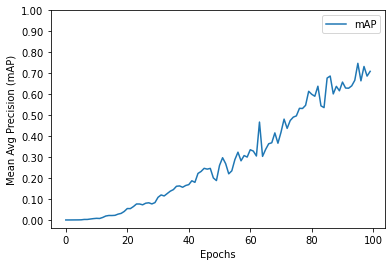

In [66]:
plot_object_detection_log(od_model, 'mAP tracking for job: ' + od_model._current_job_name)

### 8. Deploy the model

Note that some use cases require large sets of inferences on a predefined body of images. In those cases, you do not need to make the inferences in real time. Instead, you could use SageMaker's batch transform jobs.

In [67]:
%%time
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.p2.xlarge')

-----------------!Wall time: 8min 38s


### 9. Evaluating with the test set (Inference)

In [68]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width  = img.shape[1]
        colors = dict()
        num_detections = 0
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            num_detections += 1
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id], linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            print('{},{}'.format(class_name,score))
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        print('Number of detections: ' + str(num_detections))
        plt.show()

Now we use our endpoint to try to detect objects within an image. Since the image is a jpeg, we use the appropriate content_type to run the prediction. The endpoint returns a JSON object that we can simply load and peek into. We have packaged the prediction code into a function to make it easier to test other images. Note that we are defaulting the confidence threshold to 30% in our example, as a couple of the birds in our sample images were not being detected as clearly. Defining an appropriate threshold is entirely dependent on your use case.

In [69]:
OBJECT_CATEGORIES = classes_df['class_id'].values.tolist()

def show_bird_prediction(filename, ep, thresh=0.40):
    b = ''
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    results = endpoint_response['Body'].read()
    detections = json.loads(results)
    visualize_detection(filename, detections['prediction'], OBJECT_CATEGORIES, thresh)

In [ ]:
# Download a few test images
# !wget -q -O multi-goldfinch-1.jpg https://t3.ftcdn.net/jpg/01/44/64/36/500_F_144643697_GJRUBtGc55KYSMpyg1Kucb9yJzvMQooW.jpg
# !wget -q -O northern-flicker-1.jpg https://upload.wikimedia.org/wikipedia/commons/5/5c/Northern_Flicker_%28Red-shafted%29.jpg
# !wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
# !wget -q -O blue-jay-1.jpg https://cdn12.picryl.com/photo/2016/12/31/blue-jay-bird-feather-animals-b8ee04-1024.jpg
# !wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg

In [70]:
def test_model():
    show_bird_prediction('./img/hummingbird-1.jpg', object_detector.endpoint)
    show_bird_prediction('./img/blue-jay-1.jpg', object_detector.endpoint)
    show_bird_prediction('./img/multi-goldfinch-1.jpg', object_detector.endpoint)
    show_bird_prediction('./img/northern-flicker-1.jpg', object_detector.endpoint)
    show_bird_prediction('./img/northern-cardinal-1.jpg', object_detector.endpoint)

068.Ruby_throated_Hummingbird,0.49939313530921936
Number of detections: 1


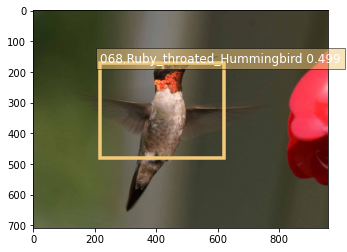

073.Blue_Jay,0.6291905641555786
Number of detections: 1


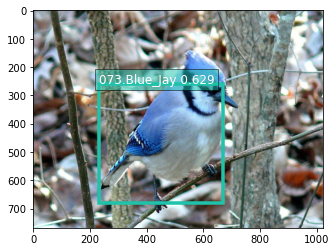

047.American_Goldfinch,0.666891872882843
047.American_Goldfinch,0.48874789476394653
Number of detections: 2


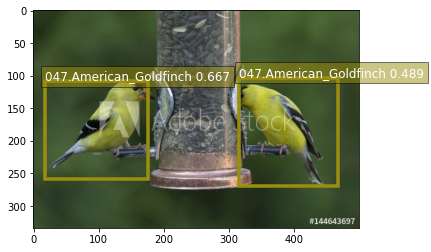

036.Northern_Flicker,0.7267725467681885
Number of detections: 1


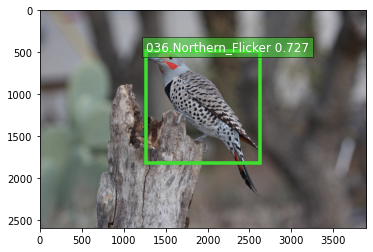

017.Cardinal,0.6009775996208191
Number of detections: 1


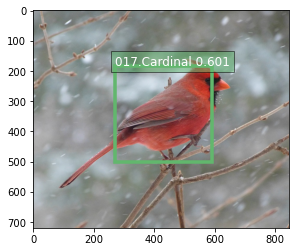

In [71]:
test_model()

### 10. Close the SageMaker Instance

In [72]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

### 11. (optional) Improve the model

In [ ]:
# Define Function to Flip the Images Horizontally (on the X Axis)
from PIL import Image

def flip_images():
    print('Flipping images...')
    
    SIZE_COLS  = ['idx','width','height']
    IMAGE_COLS = ['image_pretty_name','image_file_name']
    LABEL_COLS = ['image_pretty_name','class_id']
    BBOX_COLS  = ['image_pretty_name', 'x_abs', 'y_abs', 'bbox_width', 'bbox_height']
    SPLIT_COLS = ['image_pretty_name', 'is_training_image']

    images_df = pd.read_csv(BASE_DIR + 'images.txt',
                            sep=' ', names=IMAGE_COLS, header=None)
    image_class_labels_df = pd.read_csv(BASE_DIR + 'image_class_labels.txt',
                            sep=' ', names=LABEL_COLS, header=None)
    bboxes_df = pd.read_csv(BASE_DIR + 'bounding_boxes.txt',
                            sep=' ', names=BBOX_COLS, header=None)
    split_df = pd.read_csv(BASE_DIR + 'train_test_split.txt',
                            sep=' ', names=SPLIT_COLS, header=None)

    NUM_ORIGINAL_IMAGES = images_df.shape[0]

    rows_list        = []
    bbox_rows_list   = []
    size_rows_list   = []
    label_rows_list  = []
    split_rows_list  = []

    idx = 0

    full_df = images_df.copy()
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')
    full_df = pd.merge(full_df, bboxes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, split_df, on='image_pretty_name')
    full_df.sort_values(by=['index'], inplace=True)

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['class_id'].isin(CLASSES)
        full_df = full_df[criteria]

    for rel_image_fn in full_df['image_file_name']:
        idx += 1
        full_img_content = full_df[(full_df.image_file_name == rel_image_fn)]

        class_id = full_img_content.iloc[0].class_id

        img = Image.open(IMAGES_DIR + rel_image_fn)

        width, height = img.size

        new_idx = idx + NUM_ORIGINAL_IMAGES

        flip_core_file_name = rel_image_fn[:-4] + '_flip.jpg'
        flip_full_file_name = IMAGES_DIR + flip_core_file_name

        img_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_flip.save(flip_full_file_name)

        # append a new image
        dict = {'image_pretty_name': new_idx, 'image_file_name': flip_core_file_name}
        rows_list.append(dict)

        # append a new split, use same flag for flipped image from original image
        is_training_image = full_img_content.iloc[0].is_training_image
        split_dict = {'image_pretty_name': new_idx, 'is_training_image': is_training_image}
        split_rows_list.append(split_dict)

        # append a new image class label
        label_dict = {'image_pretty_name': new_idx, 'class_id': class_id}
        label_rows_list.append(label_dict)

        # add a size row for the original and the flipped image, same height and width
        size_dict = {'idx': idx, 'width': width, 'height': height}
        size_rows_list.append(size_dict)

        size_dict = {'idx': new_idx, 'width': width, 'height': height}
        size_rows_list.append(size_dict)

        # append bounding box for flipped image

        x_abs = full_img_content.iloc[0].x_abs
        y_abs = full_img_content.iloc[0].y_abs
        bbox_width  = full_img_content.iloc[0].bbox_width
        bbox_height = full_img_content.iloc[0].bbox_height
        flipped_x_abs = width - bbox_width - x_abs

        bbox_dict = {'image_pretty_name': new_idx, 'x_abs': flipped_x_abs,
                    'y_abs': y_abs, 'bbox_width': bbox_width, 'bbox_height': bbox_height}
        bbox_rows_list.append(bbox_dict)

    print('Done looping through original images')

    images_df = images_df.append(rows_list)
    images_df[IMAGE_COLS].to_csv(IMAGE_FILE, sep=' ', index=False, header=None)
    bboxes_df = bboxes_df.append(bbox_rows_list)
    bboxes_df[BBOX_COLS].to_csv(BBOX_FILE, sep=' ', index=False, header=None)
    split_df = split_df.append(split_rows_list)
    split_df[SPLIT_COLS].to_csv(SPLIT_FILE, sep=' ', index=False, header=None)
    sizes_df = pd.DataFrame(size_rows_list)
    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=' ', index=False, header=None)
    image_class_labels_df = image_class_labels_df.append(label_rows_list)
    image_class_labels_df[LABEL_COLS].to_csv(LABEL_FILE, sep=' ', index=False, header=None)

    print('Done saving metadata in text files')

##### Re-train the model with the expanded dataset

In [ ]:
%%time

BBOX_FILE  = BASE_DIR + 'bounding_boxes_with_flip.txt'
IMAGE_FILE = BASE_DIR + 'images_with_flip.txt'
LABEL_FILE = BASE_DIR + 'image_class_labels_with_flip.txt'
SIZE_FILE  = BASE_DIR + 'sizes_with_flip.txt'
SPLIT_FILE = BASE_DIR + 'train_test_split_with_flip.txt'

# add a set of flipped images
flip_images()

# show the new full set of images for a species
show_species('017.Cardinal')

# create new sizes file
gen_image_size_file()

# re-create and re-deploy the RecordIO files with the updated set of images
train_df, val_df = gen_list_files()
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/
sess.upload_data(path='birds_ssd_sample_train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='birds_ssd_sample_val.rec', bucket=bucket, key_prefix=validation_channel)

# account for the new number of training images
set_hyperparameters(100, '33,67')

# re-train
od_model.fit(inputs=data_channels, logs=True)

# check out the new accuracy
plot_object_detection_log(od_model, 'mAP tracking for job: ' + od_model._current_job_name)

##### Re-deploy the model and perform inference 

In [ ]:
# host the updated model
object_detector = od_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# test the new model
test_model()

##### Close the SageMaker Instance

In [ ]:
# delete the new endpoint
sagemaker.Session().delete_endpoint(object_detector.endpoint)